In [6]:
import math
import os
import re
import altair as alt
import numpy as np
import pandas as pd
import scipy.stats
import yaml
import neutcurve
import scipy.stats
print(f"Using `neutcurve` version {neutcurve.__version__}")
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, NullFormatter
import seaborn as sns

# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

#import altair themes from /data/custom_analyses_data/theme.py and enable
import theme
alt.themes.register('main_theme', theme.main_theme)
alt.themes.enable('main_theme')
os.chdir('/fh/fast/bloom_j/computational_notebooks/tmcmahon/2024/02_RSV/RSV_evolution_neut') #sets working directory to repo/project root folder
plt.rcParams['svg.fonttype'] = 'none' #from bernadeta, for correct font svg output

Using `neutcurve` version 2.1.0


In [7]:
# Load the Excel file
file_path = "01_data/other/BEIRefSeraTiters.xlsx"  # Update this to your file location
df = pd.read_excel(file_path)

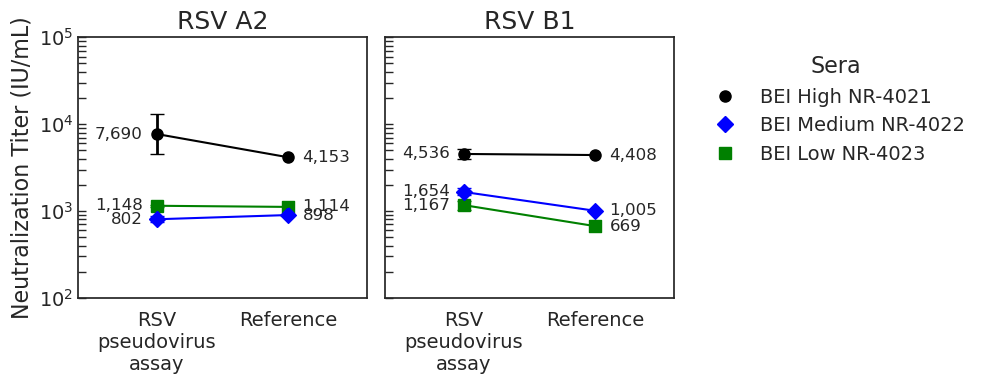

In [9]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'  # Or replace with your choice

# Strip whitespace from column names (if needed)
df.columns = df.columns.str.strip()

# Function to compute geometric mean and geometric standard deviation
def geometric_mean_and_std(group):
    geom_mean = np.exp(np.mean(np.log(group['NT50'])))
    geom_std = np.exp(np.std(np.log(group['NT50'])))
    return pd.Series({'geom_mean': geom_mean, 'geom_std': geom_std})

# Compute geometric means and standard deviations grouped by virus and sera category
summary_stats = df.groupby(['virus', 'sera', 'category']).apply(geometric_mean_and_std, include_groups=False).reset_index()

# Pivot the table to have 'measured' and 'reference' side-by-side for slope graph
pivoted_stats = summary_stats.pivot(index=['virus', 'sera'], columns='category', values=['geom_mean', 'geom_std'])
pivoted_stats.columns = ['geom_mean_measured', 'geom_mean_reference', 'geom_std_measured', 'geom_std_reference']
pivoted_stats = pivoted_stats.reset_index()

# Initialize the plot with customizable width per facet
facet_width = 3.5  # Specify width per facet
plt.figure(figsize=(facet_width * 2, 4))  # Width scales with the number of facets
sns.set(style="white")  # Remove grid lines

# Define marker styles and colors for different sera
marker_styles = {'BEI High NR-4021': 'o', 'BEI Low NR-4023': 's', 'BEI Medium NR-4022': 'D'}
sera_colors = {'BEI High NR-4021': 'black', 'BEI Low NR-4023': 'green', 'BEI Medium NR-4022': 'blue'}
legend_handles = []  # Collect handles for the legend manually

# Facet plot for each virus
for i, (virus, group) in enumerate(pivoted_stats.groupby('virus')):
    ax = plt.subplot(1, 2, i + 1, sharey=plt.gca() if i > 0 else None)

    # Set y-scale to log
    ax.set_yscale('log')

    # Set major ticks using LogLocator
    major_locator = LogLocator(base=10.0, subs=(1.0,), numticks=4)
    ax.yaxis.set_major_locator(major_locator)

    # Disable minor ticks
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=(), numticks=0))  # Prevents minor tick generation
    ax.yaxis.set_minor_formatter(NullFormatter())  # Hides any residual minor ticks

    # Set y-ticks and custom labels
    log_ticks = [10**2, 10**3, 10**4, 10**5]
    ax.set_yticks(log_ticks)
    ax.set_yticklabels([r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$'], fontsize=14)

    # Customize major ticks to be dash-like
    ax.tick_params(
        axis='y',
        which='major',
        direction='inout',
        length=10,
        width=1.5,
        left=True,
        right=False
    )


    for _, row in group.iterrows():
        # Calculate the error bars as differences from the geometric mean
        yerr_measured = [[row['geom_mean_measured'] - (row['geom_mean_measured'] / row['geom_std_measured'])],
                         [(row['geom_mean_measured'] * row['geom_std_measured']) - row['geom_mean_measured']]]

        # Plot the line connecting the points with the same color as the sera
        ax.plot(
            [-0.1, 1.1],  # Adjust x-coordinates to control spacing
            [row['geom_mean_measured'], row['geom_mean_reference']],
            linestyle='-', color=sera_colors[row['sera']], linewidth=1.5
        )

        # Plot the points with error bars for measured values
        handle = ax.errorbar(
            [-0.1],
            [row['geom_mean_measured']],
            yerr=yerr_measured,
            fmt=marker_styles[row['sera']],
            label=None,  # Avoid labels to prevent duplication
            markersize=8,
            linewidth=2,
            capsize=5,
            color=sera_colors[row['sera']]
        )
        if row['sera'] not in [h.get_label() for h in legend_handles]:  # Collect legend handles without duplicates
            legend_handles.append(plt.Line2D([0], [0], marker=marker_styles[row['sera']], color=sera_colors[row['sera']], linestyle='None', markersize=8, label=row['sera']))
        
        # Plot the points without error bars for reference values
        ax.scatter(
            [1.1],
            [row['geom_mean_reference']],
            marker=marker_styles[row['sera']],
            s=64,  # Control marker size
            color=sera_colors[row['sera']]
        )

        # Annotate points and adjust distance from points
        ax.text(-0.23, row['geom_mean_measured'], f"{int(row['geom_mean_measured']):,}", ha='right', va='center', fontsize=12)
        ax.text(1.23, row['geom_mean_reference'], f"{int(row['geom_mean_reference']):,}", ha='left', va='center', fontsize=12)

    ax.set_title(virus, fontsize=18)
    ax.set_yscale('log')
    ax.set_ylim(1e2, 1e5)  # Set y-axis limits
    if i == 0:
        ax.set_ylabel('Neutralization Titer (IU/mL)', fontsize=16)
    else:
        ax.tick_params(labelleft=False)  # Hide y-axis labels for the right facet
    ax.tick_params(axis='y', which='both', direction='in', length=6, width=1, right=False, left=True, labelsize=14)  # Ticks only on the left
    ax.set_xticks([-0.1, 1.1])
    ax.set_xticklabels(['RSV\npseudovirus\nassay', 'Reference'], rotation=0, fontsize=14, ha='center')
    plt.subplots_adjust(wspace=0.5)  # Increase space between subplots
    ax.margins(x=0.6)  # Add more space between plot edges and values

# Adjust layout and add legend in the specified order
ordered_handles = [h for label in ['BEI High NR-4021', 'BEI Medium NR-4022', 'BEI Low NR-4023'] for h in legend_handles if h.get_label() == label]
plt.tight_layout()
plt.legend(handles=ordered_handles, title='Sera', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16, frameon=False)
#os.makedirs('03_ouput/plots', exist_ok=True)
plt.savefig('03_output/plots/ReferenceSera_faceted_slope_graph_narrowV2.svg', format='svg')
#plt.savefig('03_ouput/plots/faceted_slope_graph_narrowV2.pdf', format='pdf')
plt.show()
